In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress

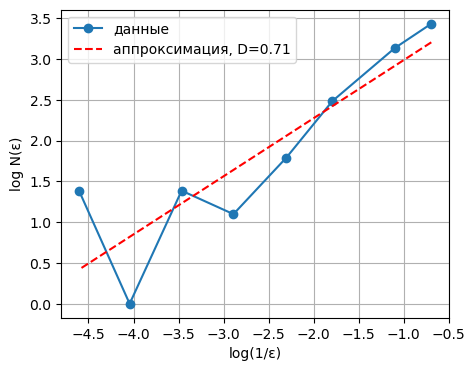

Метрическая размерность D ≈ 0.71


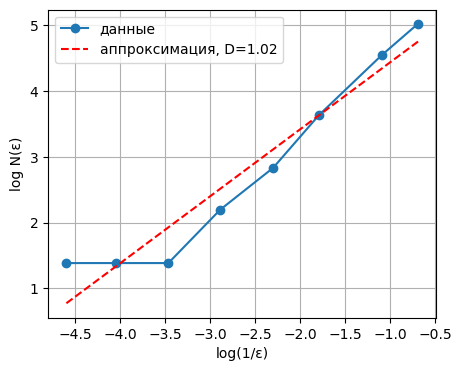

Метрическая размерность D ≈ 1.02


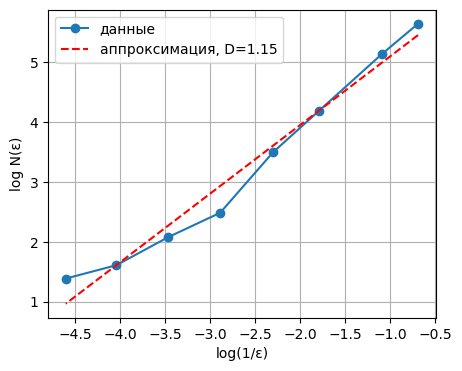

Метрическая размерность D ≈ 1.15


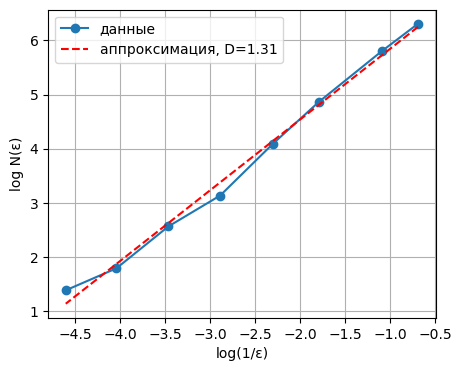

Метрическая размерность D ≈ 1.31


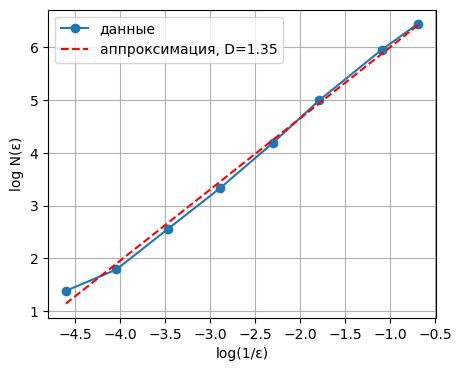

Метрическая размерность D ≈ 1.35


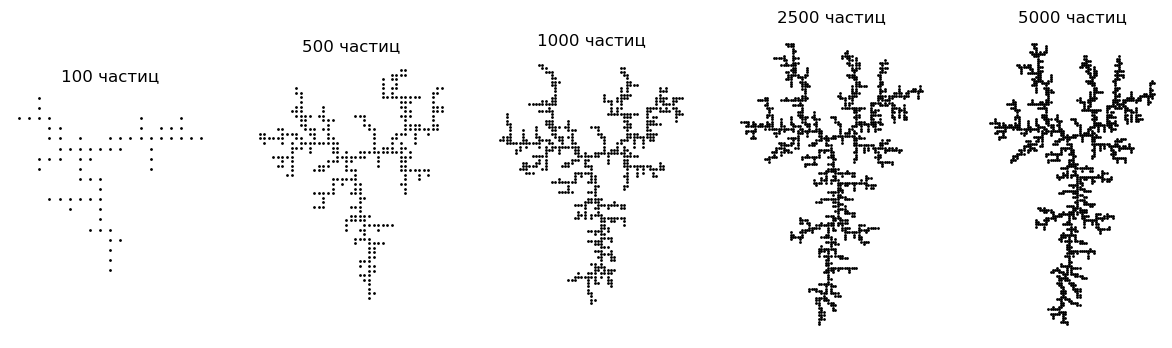

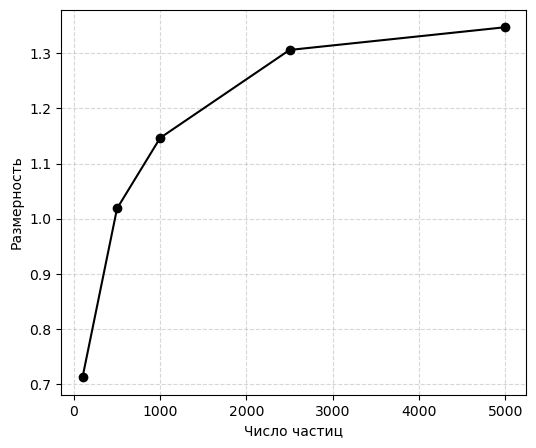

In [22]:
L = 201
center = L // 2
max_radius = L // 2 - 5
N_particles = 5000
snapshots_steps = [100, 500, 1000, 2500, 5000]


grid = np.zeros((L, L), dtype=bool)
grid[center, center] = True
snapshots = []
dimensions = []  


def box_counting_dimension(grid, min_box=2, max_box=None, n_scales=8, plot=True):
    n = grid.shape[0]
    if max_box is None:
        max_box = n // 2

    sizes = np.unique(np.logspace(np.log10(min_box), np.log10(max_box), n_scales, dtype=int))
    Ns = []

    for s in sizes:
        count = 0
        for i in range(0, n, s):
            for j in range(0, n, s):
                if np.any(grid[i:i+s, j:j+s]):
                    count += 1
        Ns.append(count)

    sizes = np.array(sizes)
    Ns = np.array(Ns, dtype=float)
    valid = (Ns > 0) & (sizes > 1)
    if valid.sum() < 3:
        return np.nan

    log_eps = np.log(1/sizes[valid])
    log_N = np.log(Ns[valid])
    slope, intercept, r_value, p_value, std_err = linregress(log_eps, log_N)

    if plot:
        plt.figure(figsize=(5,4))
        plt.plot(log_eps, log_N, 'o-', label='данные')
        plt.plot(log_eps, intercept + slope*log_eps, 'r--', label=f'аппроксимация, D={slope:.2f}')
        plt.xlabel('log(1/ε)')
        plt.ylabel('log N(ε)')
        plt.legend()
        plt.grid(True)
        plt.show()

    return slope

def random_step(x, y):
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    weights = [2, 2, 1, 1]
    dx, dy = directions[np.random.choice(4, p=np.array(weights)/sum(weights))]
    return x + dx, y + dy

def is_adjacent_to_cluster(x, y):
    for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
        if grid[x+dx, y+dy]:
            return True
    return False

def spawn_particle(radius):
    angle = 2 * np.pi * np.random.rand()
    x = int(center + radius * np.cos(angle))
    y = int(center + radius * np.sin(angle))
    return x, y

def cluster_radius():
    coords = np.argwhere(grid)
    dists = np.sqrt((coords[:,0]-center)**2 + (coords[:,1]-center)**2)
    return dists.max() if len(dists) > 0 else 0


for n in range(N_particles):
    r_cluster = cluster_radius()
    start_r = int(r_cluster + 5)
    x, y = spawn_particle(start_r)
    
    for step in range(10000):
        x, y = random_step(x, y)
        if x <= 1 or x >= L-2 or y <= 1 or y >= L-2:
            break
        if is_adjacent_to_cluster(x, y):
            grid[x, y] = True
            break
        if np.sqrt((x-center)**2 + (y-center)**2) > max_radius:
            break

    if (n+1) in snapshots_steps:
        snapshots.append(grid.copy())
        D = box_counting_dimension(grid)
        dimensions.append(D)
        print(f"Метрическая размерность D ≈ {D:.2f}")


fig, axes = plt.subplots(1, len(snapshots), figsize=(15, 4))
for ax, g, num in zip(axes, snapshots, snapshots_steps):
    coords = np.argwhere(g)
    ax.scatter(coords[:,0], coords[:,1], color='black', s=1)
    ax.set_facecolor('white')
    ax.set_title(f'{num} частиц', color='black')
    ax.set_aspect('equal')
    ax.axis('off')
plt.suptitle('', color='black', fontsize=12)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(snapshots_steps, dimensions, 'o-k')
plt.xlabel('Число частиц', color='black')
plt.ylabel('Размерность', color='black')
plt.title('', color='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

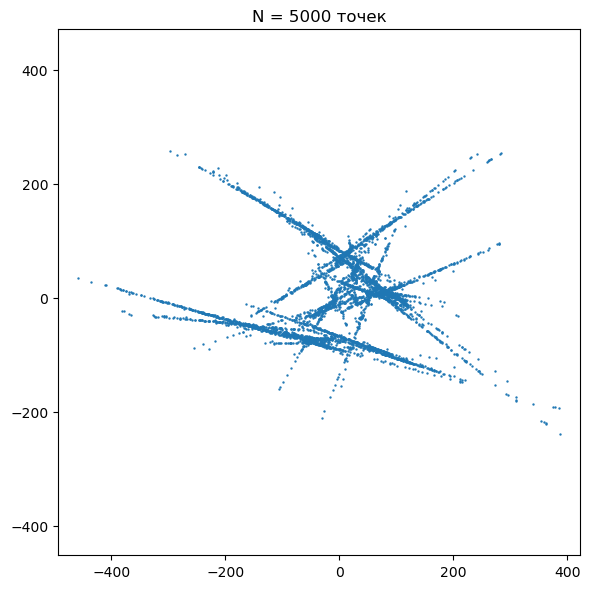

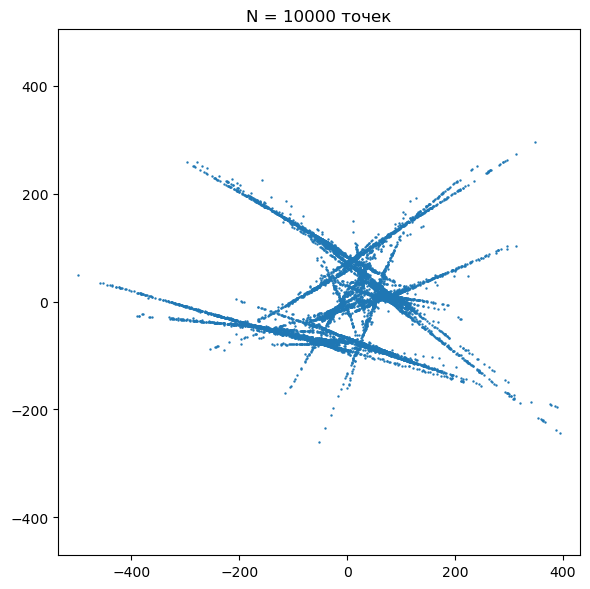

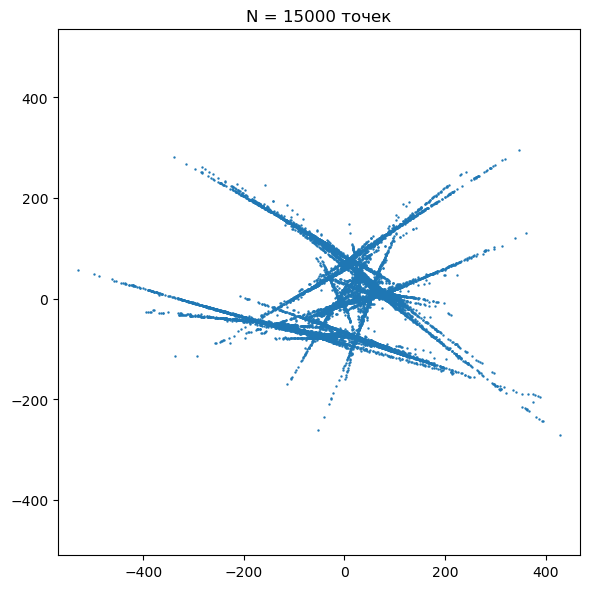

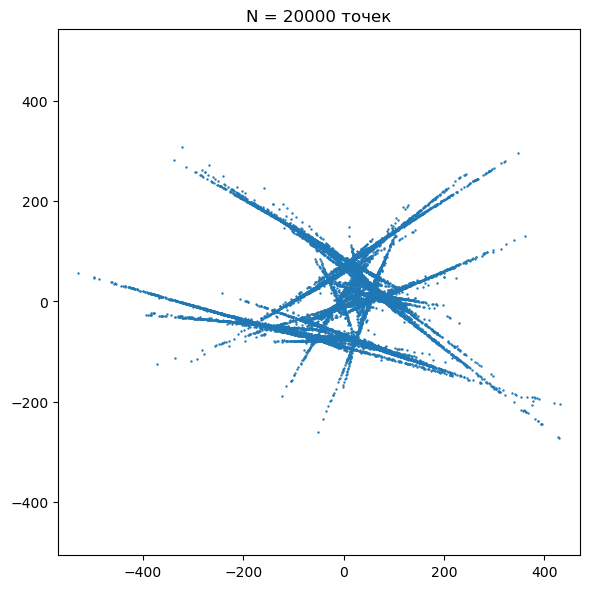

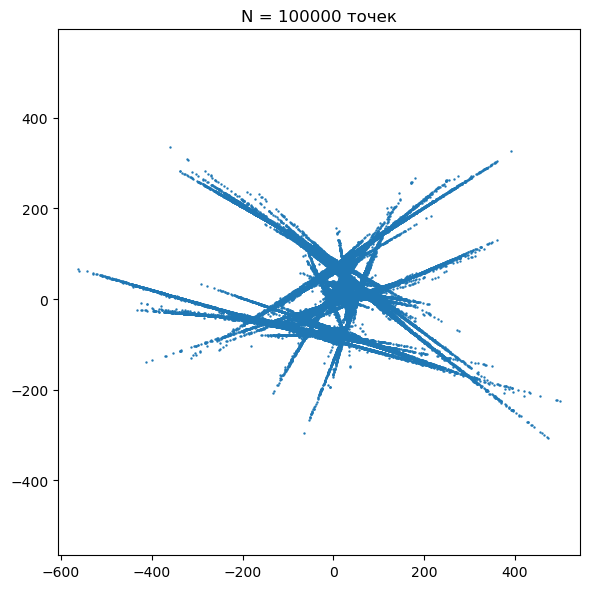

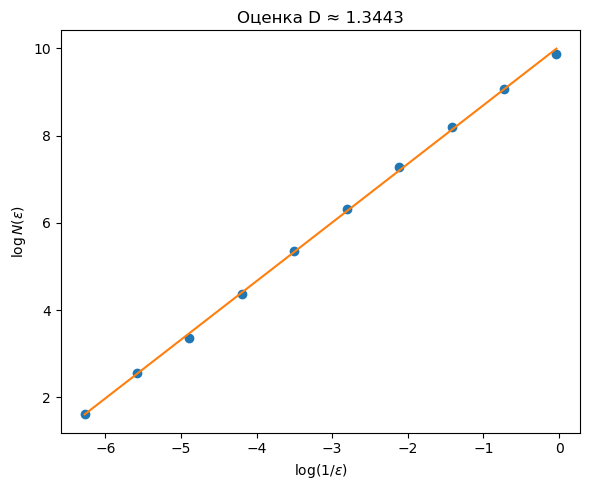

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pandas as pd

# зададим матрицы и векторы для отображений
A1 = np.array([[ 0.754,  0.568],
               [-0.500, -0.576]])
b1 = np.array([28.586, 49.567])

A2 = np.array([[-0.611,  0.476],
               [-0.564, -0.320]])
b2 = np.array([20.525, 29.918])

A3 = np.array([[ 0.243, -1.568],
               [-0.144,  0.324]])
b3 = np.array([-49.663, -69.656])

#объеденим в массив для удобства 
As = [A1, A2, A3]
bs = [b1, b2, b3]

#метод для нахождения точек 
def iterate_ifs(n_points, discard=0, seed=55):
    rng = np.random.default_rng(seed) # генератор случайных чисел 
    pts = np.zeros((n_points+discard, 2)) # массив точек 
    x = np.array([0.0, 0.0]) # начальная точка
    for i in range(n_points+discard):
        k = rng.integers(0,3)  # равновероятный выбор отображения
        x = As[k] @ x + bs[k] # @ - синт. сахар для матричного умножения numpy.matmul
        pts[i] = x
    return pts[discard:]

counts = [5000, 10000,15000, 20000,100000]
datasets = {}
for c in counts:
    datasets[c] = iterate_ifs(c, discard=0, seed=42)

#отрисовка
def plot_scatter(points, title):
    plt.figure(figsize=(6,6))
    plt.scatter(points[:,0], points[:,1], s=0.5)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

for c, pts in datasets.items():
    plot_scatter(pts, f"N = {c} точек")

def box_count(points, eps):
    # разбиваем на квадраты размера eps и считаем непустые клетки
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)
    nx = math.ceil((x_max - x_min) / eps)
    ny = math.ceil((y_max - y_min) / eps)
    # индекс каждой точки
    ix = np.floor((points[:,0] - x_min) / eps).astype(int)
    iy = np.floor((points[:,1] - y_min) / eps).astype(int)
    # кодируем клетки и считаем уникальные
    codes = ix * (ny+1) + iy
    return len(np.unique(codes))

# для оценки матреической размерности используем самый большой набор точек
points = datasets[counts[-1]]


span = max(np.ptp(points[:,0]), np.ptp(points[:,1]))


ks = np.arange(1, 11)
epss = span / (2**ks)

box_counts = [box_count(points, eps) for eps in epss]

log_eps = np.log(epss)
log_N = np.log(box_counts)
slope, intercept = np.polyfit(log_eps, log_N, 1)
D_est = -slope


plt.figure(figsize=(6,5))
plt.plot(-log_eps, log_N, marker='o', linestyle='none')
# линия аппроксимации
xs = np.linspace(-log_eps.min(), -log_eps.max(), 100)
fit_line = (slope * np.log(np.exp(-xs)) + intercept) 
plt.plot(xs, fit_line, linestyle='-')
plt.xlabel(r'$\log(1/\epsilon)$')
plt.ylabel(r'$\log N(\epsilon)$')
plt.title(f'Оценка D ≈ {D_est:.4f}')
plt.tight_layout()
plt.show()



